In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p Drive
# !google-drive-ocamlfuse Drive

In [3]:
from google.colab import drive
drive.mount('/content/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from itertools import product

os.chdir('/content/Drive/My Drive/Colab Notebooks/2019_AI_CUP_LABELING/labeling_cowork_folder')
os.getcwd()

'/content/Drive/My Drive/Colab Notebooks/2019_AI_CUP_LABELING/labeling_cowork_folder'

# Runtime Environment  
* python >= 3.6
* pytorch >= 1.0
* pandas
* nltk
* numpy
* sklearn
* pickle
* tqdm
* json

# Data processing

## 刪除多於資訊 (Remove redundant information)  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分先抽走。  
In dataset, we reserved lots of information. But in this tutorial, we don't need them, so we need to discard them.

In [5]:
import pandas as pd

dataset = pd.read_csv('raw_data/task1_trainset.csv', dtype=str)
dataset.head()

,Id,Title,Abstract,Authors,Categories,Created Date,Task 1
0,D00001,A Brain-Inspired Trust Management Model to Ass...,Rapid popularity of Internet of Things (IoT) a...,Mahmud/Kaiser/Rahman/Rahman/Shabut/Al-Mamun/Hu...,cs.CR/cs.AI/q-bio.NC,2018-01-11,BACKGROUND OBJECTIVES METHODS METHODS RESULTS ...
1,D00002,On Efficient Computation of Shortest Dubins Pa...,"In this paper, we address the problem of compu...",Sadeghi/Smith,cs.SY/cs.RO/math.OC,2016-09-21,OBJECTIVES OTHERS METHODS/RESULTS RESULTS RESULTS
2,D00003,Data-driven Upsampling of Point Clouds,High quality upsampling of sparse 3D point clo...,Zhang/Jiang/Yang/Yamakawa/Shimada/Kara,cs.CV,2018-07-07,BACKGROUND OBJECTIVES METHODS METHODS METHODS ...
3,D00004,Accessibility or Usability of InteractSE? A He...,Internet is the main source of information now...,Aqle/Khowaja/Al-Thani,cs.HC,2018-08-29,BACKGROUND BACKGROUND BACKGROUND OBJECTIVES OB...
4,D00005,Spatio-Temporal Facial Expression Recognition ...,Automated Facial Expression Recognition (FER) ...,Hasani/Mahoor,cs.CV,2017-03-20,BACKGROUND BACKGROUND BACKGROUND BACKGROUND ME...


In [0]:
# 句子有一些換行沒處理好
dataset["Abstract"] = dataset["Abstract"].str.replace("- ", "")

dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

## 資料切割  (Partition)
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   

**- Need 5-fold cv to validate training result**

In [0]:
from sklearn.model_selection import StratifiedKFold, KFold

trainset_folds = []
trainset_folds = []

valset_folds = []
valset_folds = []

tmp_train = {}
tmp_val = {}

X = dataset["Abstract"]
y = dataset["Task 1"]

# 用GROUP K-FOLD分類別? 先改用K-Fold

K_folder = KFold(n_splits=10, random_state=42, shuffle=False)
for i, (train_index, val_index) in enumerate(K_folder.split(X, y)):

    tmp_train['Abstract'] = X[train_index]
    tmp_train['Label'] = y[train_index]

    tmp_val['Abstract'] = X[val_index]
    tmp_val['Label'] = y[val_index]

    # 有一個split會反過來 (Stratified K-Fold)
    # if i == 0:
    #   continue

    trainset_folds.append(pd.DataFrame(data=tmp_train))
    valset_folds.append(pd.DataFrame(data=tmp_val))

    # print("Stratified Train Index:", train_index)
    # print("Stratified Test Index:", test_index)
    # print("Stratified y_train:", y[train_index])
    # print("Stratified y_test:", y[test_index],'\n')

# train_test_split(dataset, test_size=0.2, random_state=42)

In [0]:
trainset_folds[9]

,Abstract,Label
0,Rapid popularity of Internet of Things (IoT) a...,BACKGROUND OBJECTIVES METHODS METHODS RESULTS ...
1,"In this paper, we address the problem of compu...",OBJECTIVES OTHERS METHODS/RESULTS RESULTS RESULTS
2,High quality upsampling of sparse 3D point clo...,BACKGROUND OBJECTIVES METHODS METHODS METHODS ...
3,Internet is the main source of information now...,BACKGROUND BACKGROUND BACKGROUND OBJECTIVES OB...
4,Automated Facial Expression Recognition (FER) ...,BACKGROUND BACKGROUND BACKGROUND BACKGROUND ME...
...,...,...
6295,Activity detection is a fundamental problem in...,BACKGROUND BACKGROUND OBJECTIVES METHODS METHO...
6296,We address the problem of using hand-drawn ske...,BACKGROUND/OBJECTIVES METHODS METHODS METHODS ...
6297,This article extends the Generalized Asypmtoti...,OBJECTIVES METHODS RESULTS
6298,We consider generation and comprehension of na...,BACKGROUND OBJECTIVES METHODS METHODS METHODS ...


In [0]:
def save_k_fold_data(data, name="train_data_fold", fold=10):
  """
  X_data: list of DF
  y_data: list of DF
  """
  for i in range(fold):
    data[i].to_csv("K_fold_data/" + name + "_" + str(i) + ".csv", index=None)
fold=10
# save_k_fold_data(data=trainset_folds, name="train_data_fold", fold=fold)
# save_k_fold_data(data=valset_folds, name="valid_data_fold", fold=fold)

In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

# trainset.to_csv('train_test_split_data/trainset.csv',index=False)
# validset.to_csv('train_test_split_data/validset.csv',index=False)

In [10]:
trainset.iloc[100]["Abstract"].split("$$$")

['We present a new family of one-coincidence sequence sets suitable for frequency hopping code division multiple access (FH-CDMA) systems with dispersed (low density) sequence elements.',
 'These sets are derived from one-coincidence prime sequence sets, such that for each one-coincidence prime sequence set there is a new one-coincidence set comprised of sequences with dispersed sequence elements, required in some circumstances, for FH-CDMA systems.',
 'Getting rid of crowdedness of sequence elements is achieved by doubling the size of the sequence element alphabet.',
 'In addition, this doubling process eases control over the distance between adjacent sequence elements.',
 'Properties of the new sets are discussed.']

In [11]:
trainset.iloc[100]["Task 1"]

'RESULTS METHODS OBJECTIVES/METHODS OBJECTIVES RESULTS'

### For test data

In [0]:
dataset = pd.read_csv('raw_data/task1_public_testset.csv', dtype=str)
dataset["Abstract"] = dataset["Abstract"].str.replace("- ", "")
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('train_test_split_data/testset.csv',index=False)

### 統計單字 (Count words)  
在訓練時，不能直接將單字直接餵入model，因為它只看得懂數字，因此我們必須把所有的單字抽取出來，並將它們打上編號，做出一個字典來對它們做轉換。
We can't feed "word" into model directly, since it can only recognize number. So, we need to know the total number of word, and give every word a unique number.  

在這裡，我們需要借助`nltk`這個library來幫忙做文字切割。當然，你也可以選擇自己寫規則來切割(通常上不建議搞死自己)。  
另外，我們也使用了`multiprocessing`來加速處理。  
In here, we split words by using `nltk library`. You can write your own rules and split it by yourself, but you won't want to do that, trust me.  
Also, we use `multiprocessing` to accelerate the process.

In [0]:
import pandas as pd
from multiprocessing import Pool
from nltk.tokenize import word_tokenize

def tokenize_by_space(sentence):
  return sentence.split(' ')

def collect_words(data_path=None, n_workers=4, dataset=None):
    if dataset is None:
      df = pd.read_csv(data_path, dtype=str)
    else:
      df = dataset
      
        
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['Abstract'].split('$$$')

    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        chunks = pool.map_async(word_tokenize, chunks)
        # chunks = pool.map_async(tokenize_by_space, chunks)
        words = set(sum(chunks.get(), []))

    return words

In [14]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
words = set()
# testset_w = pd.read_csv("train_test_split_data/testset.csv", index_col=None)
# trainset_w = pd.read_csv("train_test_split_data/trainset.csv", index_col=None)
# all_data = pd.concat([trainset_w, testset_w])
words |= collect_words('raw_data/task1_trainset.csv')
# words |= collect_words(dataset=all_data)

In [16]:
words

{'FGFT',
 'dependent',
 'TreeQN',
 'commercial-off-the-self',
 'milder',
 'Solutions',
 'accommodated',
 'idiosyncrasies',
 'argmax',
 'mixtures',
 'Cybathlon',
 'UAV-BSs',
 'chain-like',
 'cartography',
 '51.63',
 'occurrence',
 'handcrafted-based',
 'synapses',
 'cooling',
 'mysteriously',
 'Consistently',
 'property-preserving',
 'Nagarajan',
 'Brazil',
 'favors',
 'compressed-sensing-based',
 'initial',
 '4-point',
 'aggregation',
 'previous-built',
 'explores',
 'typeless-',
 'album',
 'meta-paths',
 'Handwritten',
 '0.4109',
 'Chernoff',
 '5-40',
 'emoji',
 'LWR',
 'uncooperative',
 'uniquenesses',
 'above',
 'IS-A',
 'reshaped',
 'certification',
 'traceroutes',
 'identities',
 'Producers',
 'Alexnet',
 'Opinions',
 'English-Russian',
 'tracking-by-detection',
 'curl',
 'moved',
 'FGSM',
 'ramp',
 'proton',
 'safely',
 'four-chamber',
 'single-hop',
 'tailoring',
 'Inc.',
 'robot-assisted',
 'tear',
 'L-grammars',
 'Accuracy',
 '91',
 'Codes',
 'Peer-to-Peer',
 'OOCRAN',
 'cut-p

### 爬品牌名稱來對照

In [12]:
import requests
from bs4 import BeautifulSoup
import json

r = requests.get("https://brandirectory.com/rankings/global-500-2018") #將網頁資料GET下來
soup = BeautifulSoup(r.text, "html.parser") # 將網頁資料以html.parser
# sel = soup.select("a.tight-text") # 取HTML標中的 <div class="title"></div> 中的<a>標籤存入sel
# sel
text = soup.find_all("script", type="application/ld+json")[0]
contents_dict = json.loads(text.contents[0])
# type(contents_dict)
brand_names = [d["item"]["name"] for d in contents_dict["itemListElement"]]
brand_names[:6]

['Amazon', 'Apple', 'Google', 'Samsung', 'AT&T', 'Microsoft']

In [0]:
import string
import re

punctuations = ''.join([s for s in string.punctuation if s not in ('<', '>', '-')]) #  斜線冒號留著for Others label

def word_preprocess(word):

  # remove punctuations
  word = word.translate(str.maketrans('', '', punctuations))

  # remove numbers
  if '-' not in word:
    word = re.sub(r'\d+', '', word)

  if '-' in word:
    if (np.sum([w.isdigit() for w in word]) / len(word)) > 0.8:
      word = '<numbers>'
    else:
      word = '<cool-abr>'

  # brands
  if word in brand_names:
    word = '<brand>'

  # proprietary 1
  # if len(word) > 1:
  #   if (list(word)[0] == '(') and (list(word)[-1] == ')'):
  #     word = '<abr>'

  # all uppercase
  if len(word) > 1:
    if np.sum([w.isupper() for w in word]) >= 2:
      word = '<pry>'
  
  # URL
  if word in ["http", "github", "com"]:
      word = '<url>'


  # lemmatization
  # lemma = nltk.wordnet.WordNetLemmatizer()
  # word = lemma.lemmatize(word)

  # remove single character
  # if len(list(word)) < 2:
  #   word = ""

  return word # .lower() 換成小寫分數差很多?


In [2]:
from nltk.corpus import stopwords

with Pool() as pool:
  result = pool.map(word_preprocess, words)

words_pre = set(result)

print(stopwords.words('english'))
# words_pre = set([w.lower() for w in words_pre])
# words_pre = words_pre - set(stopwords.words('english'))

words_pre = words_pre - {''}
words_pre

NameError: ignored

In [15]:
len(words_pre)

24969

In [0]:
'<brand>' in words_pre

True

pad: for padding  
unk: for word that didn't in our dicitonary

In [0]:
PAD_TOKEN = 0
UNK_TOKEN = 1
word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}
for word in words_pre:
    word_dict[word]=len(word_dict)

In [0]:
import pickle
with open('other_data/dicitonary_words_pre_v7.pkl','wb') as f:
    pickle.dump(word_dict, f)

In [18]:
len(word_dict)

24971

### 資料格式化 (Data formatting)  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
這裡，我們一樣使用`multiprocessing`來加入進行。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

In [0]:
from tqdm import tqdm_notebook as tqdm
def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'BACKGROUND':0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
    onehot = [0,0,0,0,0,0]
    for l in labels.split('/'):
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sentence, word_dict):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    # 這邊的字也要前處理~
    return [word_dict.get(word_preprocess(word), UNK_TOKEN) for word in word_tokenize(sentence)]
    
def get_dataset(data_path, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))
        
        # 有with基本上不用這個
        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    if 'Task 1' in data:
        processed['Label'] = [label_to_onehot(label) for label in data['Task 1'].split(' ')]
    if 'Label' in data:
        processed['Label'] = [label_to_onehot(label) for label in data['Label'].split(' ')]
    
    return processed

In [20]:
print('[INFO] Start processing trainset...')
train = get_dataset('train_test_split_data/trainset.csv', word_dict, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset('train_test_split_data/validset.csv', word_dict, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset('train_test_split_data/testset.csv', word_dict, n_workers=4)

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing testset...






#### Preprosses K-fold data

In [21]:
train_folds=[]
valid_folds=[]

for i in range(fold):
  print('[INFO] Start processing trainset...')
  train_folds.append(get_dataset("K_fold_data/" + "train_data_fold_" + str(i) + ".csv", word_dict, n_workers=4))
  print('[INFO] Start processing validset...')
  valid_folds.append(get_dataset("K_fold_data/" + "valid_data_fold_" + str(i) + ".csv", word_dict, n_workers=4))

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing trainset...




[INFO] Start processing validset...






In [0]:
train[0]

{'Abstract': [[16994,
   8196,
   14115,
   20872,
   13709,
   23319,
   1,
   5082,
   1,
   19045,
   1,
   461,
   1,
   4188,
   12711,
   2820,
   15006,
   1,
   23338,
   15266,
   15107,
   6785,
   21022,
   2838,
   6477,
   19787,
   5862,
   5138,
   20872,
   12469,
   6485,
   1,
   21242,
   10264,
   1],
  [8592,
   2820,
   20566,
   8875,
   4071,
   24834,
   14845,
   16022,
   1,
   20566,
   22450,
   4071,
   4831,
   9433,
   14371,
   11186,
   21134,
   461,
   1564,
   20566,
   4037,
   6330,
   1],
  [21891,
   24128,
   6415,
   21291,
   1,
   1,
   23896,
   4071,
   7453,
   22998,
   5862,
   11186,
   21134,
   21390,
   15979,
   1851,
   2820,
   22174,
   23928,
   15107,
   12694,
   2838,
   4831,
   7453,
   18035,
   1565,
   20566,
   19334,
   10480,
   1,
   5371,
   19641,
   1],
  [10265,
   6415,
   14775,
   1,
   8556,
   11990,
   1,
   1626,
   10480,
   14522,
   11186,
   21134,
   1,
   12530,
   19045,
   1,
   15381,
   461,
   

## 資料封裝 (Data packing)

為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  

To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing.

In [0]:
from torch.utils.data import Dataset
import torch
class AbstractDataset(Dataset):
    def __init__(self, data, pad_idx, max_len = 500):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_sent = max([len(data['Abstract']) for data in datas])
        max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
        batch_abstract = []
        batch_label = []
        sent_len = []
        for data in datas:
            # padding abstract to make them in same length
            pad_abstract = []
            for sentence in data['Abstract']:
                if len(sentence) > max_len:
                    pad_abstract.append(sentence[:max_len])
                else:
                    pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
            sent_len.append(len(pad_abstract))
            pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
            batch_abstract.append(pad_abstract)
            # gather labels
            if 'Label' in data:
                pad_label = data['Label']
                pad_label.extend([[0]*6]*(max_sent-len(pad_label)))
                
                batch_label.append(pad_label)
        return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

In [0]:
# TODO: 改max_len
trainData = AbstractDataset(train, PAD_TOKEN, max_len=64)
validData = AbstractDataset(valid, PAD_TOKEN, max_len=64)
testData = AbstractDataset(test, PAD_TOKEN, max_len=64)

In [0]:
## 5 fold data

trainData_folds = []
validData_folds = []

for i in range(fold):
  trainData_folds.append(AbstractDataset(train_folds[i], PAD_TOKEN, max_len=64))
  validData_folds.append(AbstractDataset(valid_folds[i], PAD_TOKEN, max_len=64))

# Model

資料處理完成後，接下來就是最重要的核心部分：`Model`。  
此次範例中我們以簡單的一層RNN + 兩層Linear layer作為示範。  
而為了解決每次的句子長度不一的問題(`linear layer必須是fixed input size`)，因此我們把所有字的hidden_state做平均，讓這一個vector代表這句話。  

In this tutorial, we're going to implement a simple model, which contain one RNN layer and two fully connected layers (Linear layer). Of course you can make it "deep".  
To solve variant sentence length problem (`input size in linear layer must be fixed`), we can average all hidden_states, and become one vector. (Perfect!)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class simpleNet(nn.Module):
    def __init__(self, vocabulary_size):
        super(simpleNet, self).__init__()
        self.embedding_size = 200  # 改embedding
        self.hidden_dim = 512
        self.embedding = nn.Embedding(vocabulary_size, self.embedding_size)
        
        self.sent_lstm = nn.LSTM(self.embedding_size,
                                 self.hidden_dim,
                                 num_layers=1,
                                 bidirectional=True,
                                 batch_first=True,
                                 # dropout=0.5
                                 )
        self.sent_lstm2 = nn.LSTM(self.hidden_dim * 2,
                                 self.hidden_dim,
                                 num_layers=1,
                                 bidirectional=True,
                                 batch_first=True,
                                 # dropout=0.5
                                 )
        self.sent_gru = nn.GRU(self.hidden_dim * 2,
                               self.hidden_dim,
                               num_layers=1,
                               bidirectional=True,
                               batch_first=True,
                               # dropout=0.2
                              )
        # 加上LSTM & dropout試試看 & batch norm
        self.batch_norm = nn.BatchNorm1d(self.hidden_dim, momentum=0.5)
        self.l1 = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.l2 = nn.Linear(self.hidden_dim, 6)
        self.dropout = nn.Dropout(0.5)

        # orthogonal initialization
        # for weight in self.sent_lstm.parameters():
        #     if len(weight.size()) > 1:
        #         # print(123)
        #         nn.init.orthogonal_(weight.data)

        # for weight in self.sent_gru.parameters():
        #     if len(weight.size()) > 1:
        #         # print(456)
        #         nn.init.orthogonal_(weight.data)
        
        # # bias initialization
        # for names in self.sent_lstm._all_weights:
        #     for name in filter(lambda n: "bias" in n,  names):
        #         bias = getattr(self.sent_lstm, name)
        #         n = bias.size(0)
        #         start, end = n//4, n//2
        #         bias.data[start:end].fill_(0.)

        # for names in self.sent_gru._all_weights:
        #     for name in filter(lambda n: "bias" in n,  names):
        #         bias = getattr(self.sent_gru, name)
        #         n = bias.size(0)
        #         start, end = n//4, n//2
        #         bias.data[start:end].fill_(0.)

    def forward(self, x):
        x = self.embedding(x)
        # https://discuss.pytorch.org/t/spatial-dropout-in-pytorch/21400
        # https://pytorch.org/docs/stable/nn.html#dropout2d
        # Spatial Dropout after embedding layer
        # x = F.dropout2d(x.permute(0, 2, 1, 3), 0.5).permute(0, 2, 1, 3)
        batch_size, sent_len, word_dim, embed_dim = x.shape
        x = x.view(batch_size, sent_len * word_dim, embed_dim)  # batch, time, features
        x, __ = self.sent_lstm(x)
        # x, __ = self.sent_lstm2(x)
        x, __ = self.sent_gru(x)
        x = x.view(batch_size, sent_len, word_dim, -1)
        x = torch.max(x, dim=2)[0]  # 選整句最大值
        # x = torch.mean(x, dim=2, keepdim=True).squeeze()  # 改成平均
        x = torch.relu(self.l1(x))
        # x = x.permute(0, 2, 1)
        # x = self.batch_norm(x)  # 加一個channel維度?
        # x = x.permute(0, 2, 1)
        # x = self.dropout(x)
        x = torch.sigmoid(self.l2(x))
        return x


In [0]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=trainData,
                            batch_size=64,
                            shuffle=True,
                            collate_fn=trainData.collate_fn,
                            num_workers=4)

for (x, y, sent_len) in dataloader:
   
   break

In [0]:
Net = simpleNet(len(word_dict))

In [0]:
Net.sent_lstm.bias_hh_l0
Net.sent_lstm.bias_hh_l0.data

tensor([-0.0030,  0.0160, -0.0217,  ..., -0.0396,  0.0279, -0.0281])

In [0]:
for weight in Net.sent_lstm.parameters():
      if len(weight.size()) > 1:
          print(weight)
          print(123)
          nn.init.orthogonal_(weight.data)
          break

Parameter containing:
tensor([[-0.0049, -0.0044, -0.0139,  ...,  0.0215, -0.0044, -0.0189],
        [ 0.0002, -0.0080,  0.0442,  ..., -0.0207, -0.0041, -0.0277],
        [-0.0103, -0.0197,  0.0263,  ..., -0.0401,  0.0231, -0.0052],
        ...,
        [ 0.0187,  0.0189,  0.0035,  ...,  0.0365, -0.0084, -0.0178],
        [ 0.0169,  0.0154, -0.0423,  ...,  0.0076,  0.0020, -0.0174],
        [-0.0013,  0.0027,  0.0277,  ...,  0.0032,  0.0196, -0.0277]],
       requires_grad=True)
123


# Training

指定使用的運算裝置  
Designate running device.

In [0]:
device='cuda' #'cuda'

定義一個算分公式, 讓我們在training能快速了解model的效能  
Define score function, let us easily observe model performance while training.  

In [0]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20) #prevent divided by zero
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


In [0]:
import os
import sys

def _run_epoch(data, epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        # dataset = trainData
        dataset = data
        shuffle = True
    else:
        description = 'Valid'
        # dataset = validData
        dataset = data
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=64,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y, sent_len) in trange:
        o_labels, batch_loss = _run_iter(x,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

def _run_iter(x, y):
    abstract = x.to(device)
    labels = y.to(device)
    # o_labels = model(abstract)

    try:
        o_labels = model(abstract)
    except RuntimeError as e:
        if 'out of memory' in str(e):
            print('| WARNING: ran out of memory, retrying batch', sys.stdout)
            sys.stdout.flush()
            for p in model.parameters():
                if p.grad is not None:
                    del p.grad  # free some memory
            torch.cuda.empty_cache()
            o_labels = model(abstract)
        else:
            raise e

    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch, name, cv=False):
    if not os.path.exists('model'):
        os.makedirs('model')
    if not os.path.exists('model/cv'):
        os.makedirs('model/cv')
    if cv:
      torch.save(model.state_dict(), 'model/cv/model_cv_' + name + '.pkl.'+str(epoch))
      with open('model/cv/history_cv_' + name + '.json', 'w') as f:
          json.dump(history, f, indent=4)
    else:
      torch.save(model.state_dict(), 'model/model_' + name + '.pkl.'+str(epoch))
      with open('model/history_' + name + '.json', 'w') as f:
          json.dump(history, f, indent=4)

## Run Model

In [0]:
# torch.cuda.memory_allocated(device=None) / 1024 / 1024 / 1024
# torch.cuda.reset_max_memory_allocated(device=None)
# torch.cuda.empty_cache()

5.132418155670166

In [59]:
from torch.utils.data import DataLoader
from tqdm import trange
import json

torch.cuda.set_device(0)

mode = "no_cv" #cv, train

vaild_f1 = 0
name = "NO_CV_LSTM_GRU"

if mode == "cv":
  overall_F1 = []
  for i in range(fold):
    model = simpleNet(len(word_dict))
    # opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
    opt = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999))
    criteria = torch.nn.BCELoss() 
    model.to(device)
    max_epoch = 6
    history = {'train' : [], 'valid' : []}

    for epoch in range(max_epoch):
        print('CV_' + str(i) + ',', 'Epoch: {}'.format(epoch))
        _run_epoch(trainData_folds[i], epoch, True)
        _run_epoch(validData_folds[i], epoch, False)
        
        save(epoch, name + "_" + str(i), cv=True)

        print("average last 2 validation F1 score:", np.mean([f1['f1'] for f1 in history['valid'][-2:]]))

        if epoch > 1:
          overall_F1.append(np.mean([f1['f1'] for f1 in history['valid'][-2:]]))

  print("Final average validation F1 score:", np.mean(overall_F1))
    
else:
  model = simpleNet(len(word_dict))
  opt = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999))
  criteria = torch.nn.BCELoss()
  model.to(device)
  max_epoch = 5
  history = {'train' : [], 'valid' : []}

  for epoch in range(max_epoch):
      print('Epoch: {}'.format(epoch))
      _run_epoch(trainData, epoch, True)
      _run_epoch(validData, epoch, False)
      save(epoch, name, cv=False)

      print("average last 2 validation F1 score:", np.mean([f1['f1'] for f1 in history['valid'][-2:]]))

Epoch: 0


RuntimeError: ignored

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=a2d914a4a5f46a92d54b6974ca14d40eb698ec1b8213470278b5fd9129837b56
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 2.8 GB  | Proc size: 3.6 GB
GPU RAM Free: 30MB | Used: 7581MB | Util 100% | Total 7611MB


In [49]:
model = simpleNet(len(word_dict))
model.to(device)
model.load_state_dict(torch.load('model/cv/model_cv_LSTM_GRU_ortho_bias0(word_pre_24971_words)_10Kfold_0.pkl.2'))

<All keys matched successfully>

## Predict

In [50]:
from torch.utils.data import DataLoader
model.train(False)
dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,  # for sent len不要亂
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x, y, sent_len) in trange:
    o_labels = model(x.to(device))
    o_labels = o_labels > 0.4
    for idx, o_label in enumerate(o_labels):
        prediction.append(o_label[:sent_len[idx]].to('cpu'))
prediction = torch.cat(prediction).detach().numpy().astype(int)

In [0]:
label_dict = {'BACKGROUND':0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}

In [52]:
reversed_word_dict = {value: key for key, value in word_dict.items()}
[reversed_word_dict[idx] for idx in x[idx][3].numpy()]

['Theoretical',
 'and',
 'practical',
 'aspects',
 'of',
 '<pry>',
 'algorithm',
 'design',
 'are',
 'discussed',
 '<unk>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [53]:
o_label

tensor([[ True, False, False, False, False, False],
        [ True, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]], device='cuda:0')

In [0]:
import numpy as np
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
        submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
        submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
        submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
        submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
        submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
        submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
        submit['METHODS'] = [0]*redundant + list(prediction[:,2])
        submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
        submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [37]:
os.getcwd()

'/content/Drive/My Drive/Colab Notebooks/2019_AI_CUP_LABELING/labeling_cowork_folder'

In [0]:
SubmitGenerator(prediction,
                'raw_data/task1_sample_submission.csv', 
                True,
                'submission/submission_6_emb200_word_pre_gru_2_layers.csv')

NameError: ignored

## 把cv模型load出來predict平均

In [0]:
model.load_state_dict(torch.load('model/cv/model_cv_gru_layer1_emb200_wordpre_for_cv_avf_0.pkl.3'))

<All keys matched successfully>

In [0]:
model = simpleNet(len(word_dict))
# opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
opt = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999))
criteria = torch.nn.BCELoss() 
model.to(device)
max_epoch = 6

In [0]:
from torch.utils.data import DataLoader

prediction_sum = np.zeros((131166, 6))
n_digits = 3
model_nums = 0

for cv in range(fold):
  for ep in range(max_epoch):
    if (ep == 3) or (ep == 4): # 只取epoch 3 & 4 的模型 (started from 0)
      dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,  # for sent len不要亂
                            collate_fn=testData.collate_fn,
                            num_workers=4)
      trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')

      model.load_state_dict(torch.load('model/cv/model_cv_LSTM_GRU_ortho_bias0(word_pre_24971_words)_10Kfold_' + str(cv) + '.pkl.' + str(ep) + ''))
      model.train(False)
      prediction = []
      for i, (x, y, sent_len) in trange:
        with torch.no_grad(): # 避免記憶體爆掉，先將grad都設為false
          o_labels = model(x.to(device))  
          o_labels = (o_labels * 10 ** n_digits).round() / (10 ** n_digits)
          # o_labels = o_labels.to('cpu')
          # o_labels = o_labels > 0.4
          for idx, o_label in enumerate(o_labels):
              prediction.append(o_label[:sent_len[idx]].to('cpu'))
      prediction = torch.cat(prediction).detach().numpy() # .astype(int)
      
      prediction_sum += prediction
      model_nums += 1

final_prediction = prediction_sum / model_nums

In [0]:
SubmitGenerator(final_prediction,
                'raw_data/task1_sample_submission.csv', 
                True,
                'submission/submission_15_LSTM_GRU_ortho_bias0(word_pre_25002_words)_10Kfold_cv_avg_origin_prob.csv')

# Plot Learning Curve

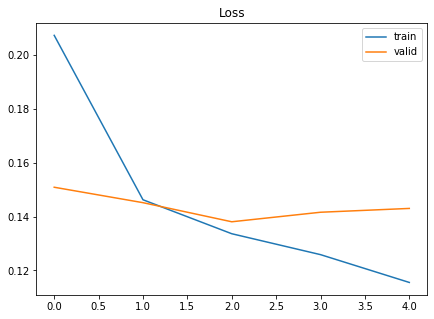

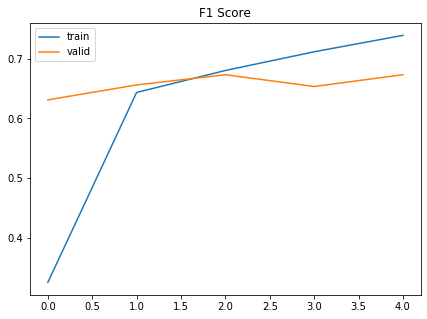

Best F1 score  [0.6734478456961903, 4]


In [0]:
import matplotlib.pyplot as plt
import json
%matplotlib inline

with open('model/history_train.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))